# Explore Winds Issue

This notebook explores the issue of improperly rotated wind data in the WRF data. 

## Background

This section explores the relevant background of post-processing the raw WRF wind data and making it available on AWS. It attempts to shed light on the current state of things - how and when each set of outputs was generated (because there are duplicate sets of outputs in different locations) - with particular concern for determining the most likely series of events taken for producing the wind data that were previously hosted on AWS, that had the issue of incorrect values.

### The issue

First, explore the issue at hand.  

In Dec 2020, Peter B noticed that ERA-Interim wind directions derived from the **production dataset** (the WRF data hosted on AWS) were incorrect. He has provided correctly rotated wind data as a reference, which can be found at: `/workspace/Shared/Tech_Projects/wrf_data/project_data/wind-issue/truth_winds_1980-01-01_00.nc`.

#### Example

Using the truth data that Peter has provided, plot the differences between the truth data and the production data.

I deleted the production data from AWS and therefore this comparison cannot utilize the *true* production data, e.g. by downloading the problematic files from AWS. I did this before I realized there was more than one place on Poseidon that had files with the same naming convention, so we actually need to sort that out before we make the comparison with the truth data.

I.e., what files were uploaded to AWS? There is only one candidate that I have found, **`/rcs/project_data/wrf_data/hourly_fix/`**, which is referenced in the `wrap_run_move_wrf_aws_s3.py` script (most recent commit with this file occurred on 2019-09-22)

So, here is a visualization of the differences between the truth data and the corresponding data in `/rcs/project_data/wrf_data/hourly_fix/`:

/home/UA/kmredilla/.localpython/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


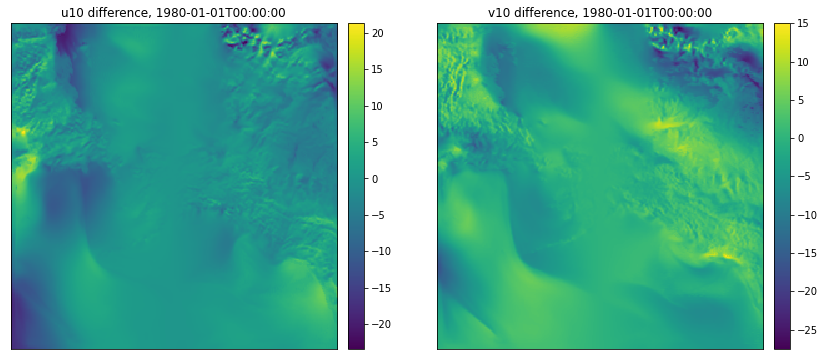

In [1]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# load truth dataset because it is small
truth_fp = "/workspace/Shared/Tech_Projects/wrf_data/project_data/wind-issue/truth_winds_1980-01-01_00.nc"
truth_ds = xr.load_dataset(truth_fp)

def plot_truth_difference(fig, var, subplot_code):
    issue_fp = f"/rcs/project_data/wrf_data/hourly_fix/{var}/{var}_hourly_wrf_ERA-Interim_historical_1980.nc"
    t = "1980-01-01T00:00:00"
    with xr.open_dataset(issue_fp) as ds:
        issue_arr = ds[var].sel(time=t).values
    
    ax = fig.add_subplot(subplot_code)
    
    im = ax.imshow(
        np.flip(truth_ds[f"{var}e"].values, 0) - issue_arr, 
        interpolation="none"
    )
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.title.set_text(f"{var} difference, {t}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    plt.colorbar(im, cax=cax)
        
    return fig

fig = plt.figure(figsize=(14, 6))

fig = plot_truth_difference(fig, "u10", 121)
fig = plot_truth_difference(fig, "v10", 122)

Viola, the issue. The differences don't match the exact same image provided by Peter, but that could just be a result of the differences in visualization software being used.

(the coordinates printed below are just to justify the verical flipping of the "truth" data set in the comparison)

In [4]:
# these snippets just demonstrate why the "truth" array needs to be flipped vertically to align properly.

# truth data
print("Truth data array bounds:")
print(f"lon start: {round(truth_ds.lon.values[0,0])};  end: {round(truth_ds.lon.values[0,-1])}")
print(f"lat start: {round(truth_ds.lat.values[0,0])};  end: {round(truth_ds.lat.values[-1,0])}\n")

# restacked data
print("Restacked data array bounds")
issue_fp = "/rcs/project_data/wrf_data/hourly_fix/u10/u10_hourly_wrf_ERA-Interim_historical_1980.nc"
with xr.open_dataset(issue_fp) as ds: 
    print(f"lon start: {round(ds.xc.values[0])};  end: {round(ds.xc.values[-1])}")
    print(f"lat start: {round(ds.yc.values[0])};  end: {round(ds.yc.values[-1])}")

Truth data array bounds:
lon start: -178.0;  end: -126.0
lat start: 37.0;  end: 66.0

Restacked data array bounds
lon start: -2610000.0;  end: 2610000.0
lat start: -182425.0;  end: -5402425.0


#### Wind direction only?

Peter initially believed that this issue only affected wind directions derived from the components, not the speeds. This information was passed onto stakeholders that had already accessed the data. Test that this is the case:

In [19]:
# compute wind directions and speeds from truth data, 
# compare with wind directions / speeds from original data

import math

def convert_uv(uv):
    """Convert U,V wind components to speed and direction"""
    u, v = uv
    # compute wind direction
    angle = math.atan2(v, u) * 180 / math.pi
    if angle < 0:
        angle += 360
    # convert to degrees from North
    wd = 270 - angle
    if angle >= 270:
        wd += 360
    
    # compute wind speed
    ws = math.sqrt(u ** 2 + v ** 2) * 2.23694
    
    # return just wind speed
    #return round(ws, 3), round(wd, 3)
    return round(ws, 3)

def convert_arrays(u_arr, v_arr):
    """Convert """
    uv_list = [(u, v) for u, v in zip(u_arr.flatten(), v_arr.flatten())]
    return np.array([convert_uv(uv) for uv in uv_list]).reshape(262, 262)

t = "1980-01-01T00:00:00"
with xr.open_dataset(issue_fp) as ds:
    issue_u_arr = ds["u10"].sel(time=t).values
with xr.open_dataset(issue_fp.replace("u10", "v10")) as ds:
    issue_v_arr = ds["v10"].sel(time=t).values

truth_u_arr, truth_v_arr = [np.flip(truth_ds[var].values, 0) for var in ["u10e", "v10e"]]

truth_speeds = convert_arrays(truth_u_arr, truth_v_arr)
issue_speeds = convert_arrays(issue_u_arr, issue_v_arr)

print("Truth wind speeds match issue wind speeds: ", np.all(truth_speeds == issue_speeds))

Truth wind speeds match issue wind speeds:  False


Okay, so they don't match exactly, but I think this might be a rounding error. Are they within 0.01 m/s of each other?

In [24]:
print("Truth wind speeds are within 0.01 m/s of issue wind speeds: ", np.all(np.round(truth_speeds - issue_speeds, 2) == 0))

Truth wind speeds are within 0.01 m/s of issue wind speeds:  True


Yes, so it appears that the problem really does manifest only in the wind directions derived from the data.

### Processing pipeline

Some review of the codebase in this `snap_wrf_data_prep` directory of this repo suggests the following about its useage:

The raw WRF wind output data is first "stacked" to break out the files by year and variable, and then "improved" to provide a wholesome file/metadata structure. They are then copied to the AWS S3 bucket. 

#### Code

The `snap_wrf_data_prep` directory contains all of the code for processing the raw WRF wind output (all other variables as well) including the `processing_pipeline` subdirectory which has most of the code. The "stacking" step is done with `stack_hourly_variable_year_winds.py`. The codebase is designed to be run with slurm, and the `.slurm` scripts used to run the stacking script are made with `make_variable_sbatch_by_year.py`. Shell scripts, e.g. `run_allvars_dependency_full_erain.sh`, are used to call the relevant `.slurm` scripts. 

The "improvement" is done with `processing_pipeline/improve_hourly_netcdf_strcutre.py`, which is called via slurm in `wrap_run_improve_hourly_netcdf_structure.py`, both of which are in the `processing_pipeline` subdirectory. 

Copying files to AWS is done with `wrap_run_move_wrf_aws_s3.py` which uses this `*10_ERA-Interim_historical_move_s3_aws_0.slurm` script from directory 3 to copy data in directory 2 to AWS.

#### Directories

From the processing code, `processing_pipeline/improve_hourly_netcdf_structure.py`, stacked data is contained in an `hourly/` subdirectory, and improved data is contained in an `hourly_fix` directory. The most likely directories for the source of the current production data are:

1. `/rcs/project_data/wrf_data/hourly/`: **stacked data**, raw WRF output with data broken out by year/variable
2. `/rcs/project_data/wrf_data/hourly_fix/`: **improved data**, stacked data that has had its file structure improved
3. `/workspace/Shared/Tech_Projects/wrf_data/project_data/aws_move_slurm`: slurm scripts used for moving files to AWS


## Exploration

This section explores the issue of improperly aligned winds present in the production data (AWS data, which should be the same data in directory #2 above).

### Test "stacking" step

The first step is to test stacking the raw output to see if the current stacking script produces the correct data.

First, move some sample files, including the one from which the truth data was derived, to `atlas_scratch` (not necessary, but part of the processing pipeline)

In [97]:
# copy 1980-01-01 WRF outputs to atlas_scratch
!mkdir -p /atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/1980 && cp -n /storage01/pbieniek/erain/hourly/1980/*1980-01-01* /atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/1980

# move template file that does not have permissions from atlas11
!cp -n /storage01/pbieniek/gfdl/hist/monthly/monthly_PCPT-gfdlh.nc /atlas_scratch/kmredilla/WRF/wind-issue

In [98]:
# WRF data copied
!ls /atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/1980/

WRFDS_d01.1980-01-01_00.nc  WRFDS_d01.1980-01-01_12.nc
WRFDS_d01.1980-01-01_01.nc  WRFDS_d01.1980-01-01_13.nc
WRFDS_d01.1980-01-01_02.nc  WRFDS_d01.1980-01-01_14.nc
WRFDS_d01.1980-01-01_03.nc  WRFDS_d01.1980-01-01_15.nc
WRFDS_d01.1980-01-01_04.nc  WRFDS_d01.1980-01-01_16.nc
WRFDS_d01.1980-01-01_05.nc  WRFDS_d01.1980-01-01_17.nc
WRFDS_d01.1980-01-01_06.nc  WRFDS_d01.1980-01-01_18.nc
WRFDS_d01.1980-01-01_07.nc  WRFDS_d01.1980-01-01_19.nc
WRFDS_d01.1980-01-01_08.nc  WRFDS_d01.1980-01-01_20.nc
WRFDS_d01.1980-01-01_09.nc  WRFDS_d01.1980-01-01_21.nc
WRFDS_d01.1980-01-01_10.nc  WRFDS_d01.1980-01-01_22.nc
WRFDS_d01.1980-01-01_11.nc  WRFDS_d01.1980-01-01_23.nc


Next, run the stacking script modified to accept the (much) smaller amount of input data that matches the time period and variables provided in the truth data (U10 and V10, 1980-01-01):

In [143]:
!ls /atlas_scratch/kmredilla/WRF/wind-issue/test-stack

In [145]:
# create test stacking directory
!mkdir -p /atlas_scratch/kmredilla/WRF/wind-issue/test-stack

import subprocess

test_u10_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/test-stack/u10_wrf_hourly_era_1980.nc"

command = [
    "python",
    "stack_hourly_variable_year_winds_firstday.py",
    "-i", "/atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/",
    "-id", "/storage01/pbieniek/erain/hourly/",
    "-y", "1980",
    "-f", "/workspace/Shared/Tech_Projects/wrf_data/project_data/wrf/docs/WRFDS_forecast_time_attr_erain.csv",
    "-v", "U10",
    "-o", test_u10_fp,
    "-t", "/atlas_scratch/kmredilla/WRF/wind-issue/monthly_PCPT-gfdlh.nc", # move if doesn't work
    "-a", "/workspace/Shared/Tech_Projects/wrf_data/project_data/ancillary_wrf_constants/geo_em.d01.nc",
]

subprocess.call(command)

0

Now, compare the truth data with the newly created restacked data:

In [146]:
test_u10e_ds = xr.load_dataset(test_u10_fp)

print("Truth data match manually stacked data:", np.all(test_u10e_ds.U10.values[0] == truth_ds.u10e.values))

Truth data match manually stacked data: True


So the restacking script appears to be working correctly. Now try for the other variable provided in the truth data, V10:

In [147]:
test_v10_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/test-stack/v10_wrf_hourly_era_1980.nc"

command = [
    "python",
    "stack_hourly_variable_year_winds_firstday.py",
    "-i", "/atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/",
    "-id", "/storage01/pbieniek/erain/hourly/",
    "-y", "1980",
    "-f", "/workspace/Shared/Tech_Projects/wrf_data/project_data/wrf/docs/WRFDS_forecast_time_attr_erain.csv",
    "-v", "V10",
    "-o", test_v10_fp,
    "-t", "/atlas_scratch/kmredilla/WRF/wind-issue/monthly_PCPT-gfdlh.nc", # move if doesn't work
    "-a", "/workspace/Shared/Tech_Projects/wrf_data/project_data/ancillary_wrf_constants/geo_em.d01.nc",
]

subprocess.call(command)

0

In [148]:
test_v10e_ds = xr.load_dataset(test_v10_fp)

print("Truth data match manually stacked data:", np.all(test_v10e_ds.V10.values[0] == truth_ds.v10e.values))

Truth data match manually stacked data: True


Great. So the stacking script is correct, which rules that out as the culprit. This suggests that the issue arises either in implementation of that script via slurm, or elsewhere in the processing, such as the "improve" script. 

Here is just a double check that the the manually stacked data, which we know to be the truth data, do not match the original stacked data in `/rcs/project_data/wrf_data/hourly`. These should not match because the original stacked data should have the same underlying wind component values as the improved data in the `/rcs/project_data/wrf_data/hourly_fix` directory, which is already known to *not* match the truth data. Check:

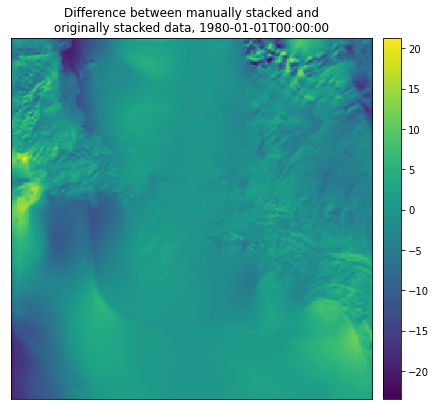

In [131]:
# original restacked U10 data in /rcs/project_data/wrf_data/hourly/u10/
hourly_fp = "/rcs/project_data/wrf_data/hourly/u10/U10_wrf_hourly_era_interim_1980.nc"
with xr.open_dataset(hourly_fp) as ds:
    hourly_arr = ds["U10"].sel(time="1980-01-01T00:00:00").values
    
fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
im = ax.imshow(
    # flip just to have irl orientation (North at top)
    np.flip(test_u10e_ds.U10.values[0] - hourly_arr, 0), interpolation="none"
)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
t = "1980-01-01T00:00:00"
ax.title.set_text(f"Difference between manually stacked and\noriginally stacked data, {t}")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im, cax=cax)
plt.show()

So the originally stacked data is incorrect, which was expected because it should be a direct match to the "improved" data in `/rcs/project_data/wrf_data/hourly_fix`. Let's test this now as well:

In [133]:
# original restacked U10 data in /rcs/project_data/wrf_data/hourly/u10/
hourly_fix_fp = "/rcs/project_data/wrf_data/hourly_fix/u10/u10_hourly_wrf_ERA-Interim_historical_1980.nc"
with xr.open_dataset(hourly_fix_fp) as ds:
    hourly_fix_arr = ds["u10"].sel(time="1980-01-01T00:00:00").values
    
print("Originally stacked data match improved data:", np.all(hourly_fix_arr == np.flip(hourly_arr, 0)))

Originally stacked data match improved data: True


So the `improve_hourly_netcdf_structure.py` script was indeed used to improve the files in the `/rcs/project_data/wrf_data/hourly/`, writing the improved files to `/rcs/project_data/wrf_data/hourly_fix/`. This rules out the `improve_hourly_netcdf_structure.py` as being the cause of the issue.

### Re-run stacking with `slurm`

The final test will be to just re-run the stacking as designed with `slurm`, to test whether this was just an issue of the final data not being run using this current codebase!

To do this, we first create relevant `.slurm` scripts that will execute the `stack_hourly_variable_year_winds.py` script, using the `processing_pipeline/make_variable_sbatch_by_year.py`. We will use a modified version of that script, `processing_pipeline/make_variable_sbatch_by_year_winds.py`, to create `.slurm` scripts for the wind variables only. 

Run this in separate shell:
`python processing_pipeline/make_variable_sbatch_by_year_winds.py`

See that slurm scripts were created:


In [161]:
!ls /atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/*.slurm

/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/U10_1970_ccsm_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/U10_1970_gfdl_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/U_1970_ccsm_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/U_1970_gfdl_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/UBOT_1970_ccsm_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/UBOT_1970_gfdl_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/V10_1970_ccsm_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/V10_1970_gfdl_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/V_1970_ccsm_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/1970/V_1970_gfdl_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/restacked/slurm_scripts/19

Now, use a modified version of the `run_allvars_dependency_full_erain.sh`, `run_winds_dependency_full_erain.sh`, to submit the jobs. This takes a while to run. When the 1980 data has completed, 

In [165]:
!ls /atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/*erain_1980*

/atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/U10_wrf_hourly_erain_1980.nc


we can check that these data match the truth data:

In [174]:
test_slurm_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/U10_wrf_hourly_erain_1980.nc"
with xr.open_dataset(test_slurm_fp) as ds:
    restacked_u10e = ds.U10.sel(time="1980-01-01T00:00:00").values
    
print("Newly restacked data match improved data:", np.all(truth_ds.u10e.values == restacked_u10e))

Newly restacked data match improved data: True


Okay, as expected, the `slurm` process is not the issue. Looks like the most recent code was just never run! Or, it may have been run and files not copied off of the scratch dir, etc.

This means stacking for all models and scenarios likely has to be re-run. 

So, run modified versions of the `run_allvars_dependency_full_<model/scenario>.sh` script for each model and scenario. 

...

So those have been running, but curious to see whether these newly restacked data are different from the original stacked data for all other models / scenarios.

Compare these for NCAR CCSM4 historical:

In [212]:
def compare_restacked_data(restacked_fp, original_fp, var, year):
    with xr.open_dataset(restacked_fp) as ds:
        restacked_arr = ds[var].sel(time=f"{year}-01-01T00:00:00").values

    with xr.open_dataset(original_fp) as ds:
        original_arr = ds[var].sel(time=f"{year}-01-01T00:00:00").values

    print("Newly restacked data match original restacked data:", np.all(original_arr == restacked_arr))


restacked_ccsm_1980_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/U10_wrf_hourly_ccsm_hist_1980.nc"
original_ccsm_1980_fp = "/rcs/project_data/wrf_data/hourly/u10/U10_wrf_hourly_ccsm_hist_1980.nc"

compare_restacked_data(restacked_ccsm_1980_fp, original_ccsm_1980_fp, "U10", 1980)

Newly restacked data match original restacked data: False


And for GFDL CM3 historical:

In [205]:
restacked_gfdl_1980_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/U10_wrf_hourly_gfdl_hist_1980.nc"
original_gfdl_1980_fp = "/rcs/project_data/wrf_data/hourly/u10/U10_wrf_hourly_gfdl_hist_1980.nc"

compare_restacked_data(restacked_gfdl_1980_fp, original_gfdl_1980_fp, "U10", 1980)

Newly restacked data match original restacked data: False


Okay, so it looks like the original stacked data do not match the newly restacked, and so are likely wrong as well. So we should assume that all of the data need to be restacked.

Or should we? I've found another spot of originally stacked data: `/rcs/project_data/WRF_DATA_SEP2019`.

In [187]:
!ls /rcs/project_data/WRF_DATA_SEP2019/u10 | head -5

U10_wrf_hourly_ccsm_hist_1970.nc
U10_wrf_hourly_ccsm_rcp85_2005.nc
U10_wrf_hourly_ccsm_rcp85_2006.nc
U10_wrf_hourly_ccsm_rcp85_2007.nc
U10_wrf_hourly_ccsm_rcp85_2008.nc


Do these data match the newly restacked data by chance?

In [206]:
restacked_ccsm_2006_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/U10_wrf_hourly_ccsm_rcp85_2006.nc"
original_ccsm_2006_fp = "/rcs/project_data/WRF_DATA_SEP2019/u10/U10_wrf_hourly_ccsm_rcp85_2006.nc"

compare_restacked_data(restacked_ccsm_2006_fp, original_ccsm_2006_fp, "U10", 2006)

Newly restacked data match original restacked data: True


Okay, so data in `/rcs/project_data/WRF_DATA_SEP2019` may have been created using the most recent version of this codebase. Let's just check a few more different files (random):

In [207]:
# 2010 CCSM U10
restacked_ccsm_2010_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/U10_wrf_hourly_ccsm_rcp85_2010.nc"
original_ccsm_2010_fp = "/rcs/project_data/WRF_DATA_SEP2019/u10/U10_wrf_hourly_ccsm_rcp85_2010.nc"

compare_restacked_data(restacked_ccsm_2010_fp, original_ccsm_2010_fp, "U10", 2010)

Newly restacked data match original restacked data: True


In [208]:
# 2030 CCSM U10
restacked_ccsm_2030_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/U10_wrf_hourly_ccsm_rcp85_2030.nc"
original_ccsm_2030_fp = "/rcs/project_data/WRF_DATA_SEP2019/u10/U10_wrf_hourly_ccsm_rcp85_2030.nc"

compare_restacked_data(restacked_ccsm_2030_fp, original_ccsm_2030_fp, "U10", 2030)

Newly restacked data match original restacked data: True


In [213]:
# 2021 CCSM V10
restacked_ccsm_2021_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/v10/V10_wrf_hourly_ccsm_rcp85_2021.nc"
original_ccsm_2021_fp = "/rcs/project_data/WRF_DATA_SEP2019/v10/V10_wrf_hourly_ccsm_rcp85_2021.nc"

compare_restacked_data(restacked_ccsm_2021_fp, original_ccsm_2021_fp, "V10", 2021)

Newly restacked data match original restacked data: True


Okay. This means the restacking has to be done for most of the future years, but not all. Will modify the relevant `run_winds_dependency_full_<model/scenario>.sh` scripts to start from a pre-specified year and commence reprocessing.

### Move off scratch space

While the re-stacking was running, we were hitting storage limitations on the scratch space. The `processing_pipeline/move_stacked_from_scratch.py` script was developed and run during re-stacking to ensure completed files were moved off of the scratch space. The `processing_pipeline/cleanup_stacked_scratch.py` was created to remove any files from `$SCRATCH_DIR` that were already present in the `$BASE_DIR`. This would have occured due to copying early on in the re-stacking process via command line to free up space.

Because some of the correctly stacked data had already been produced - data stacked using the most recent version of the code here - we only needed to re-stack a subset of the model/years, which is helpful because the stacking process takes a while. This of course results in two different locations for this correctly stacked data: the `/rcs/project_data/WRF_DATA_SEP2019` and the `/rcs/project_data/wind-issue/`. So, I think linking the previously re-stacked data to the newly restacked directory would be the best choice for now:

In [83]:
# create symlinks for all files that were already restacked before these efforts
from pathlib import Path

new_restack_dir = Path("/rcs/project_data/wrf_data/wind-issue/hourly")
old_restack_dir = Path("/rcs/project_data/WRF_DATA_SEP2019")

def create_symlinks(in_dir, out_dir):
    """Create symlinks in out_dir for files in 
    in_dir that are not present in out_dir
    """
    present_fns = [fp.name for fp in out_dir.glob("*")]
    out_fps = [out_dir.joinpath(fp.name) for fp in in_dir.glob("*") if fp.name not in present_fns]
    
    return [fp.symlink_to(in_dir.joinpath(fp.name)) for fp in out_fps]

out = [
    create_symlinks(old_restack_dir.joinpath(var), new_restack_dir.joinpath(var))
    for var in ["u", "u10", "ubot", "v", "v10", "vbot"]
]

In [86]:
!ls -l /rcs/project_data/wrf_data/wind-issue/hourly/v10

total 407442432
-rw-rw----. 1 snap-smb dyndown 1860473499 Apr 10 16:27 V10_wrf_hourly_ccsm_hist_1970.nc
-rw-rw----. 1 snap-smb dyndown 1865868435 Apr 10 16:28 V10_wrf_hourly_ccsm_hist_1971.nc
-rw-rw----. 1 snap-smb dyndown 1866704327 Apr 10 16:30 V10_wrf_hourly_ccsm_hist_1972.nc
-rw-rw----. 1 snap-smb dyndown 1867810774 Apr 10 16:31 V10_wrf_hourly_ccsm_hist_1973.nc
-rw-rw----. 1 snap-smb dyndown 1866357180 Apr 10 16:32 V10_wrf_hourly_ccsm_hist_1974.nc
-rw-rw----. 1 snap-smb dyndown 1864338425 Apr 10 16:33 V10_wrf_hourly_ccsm_hist_1975.nc
-rw-rw----. 1 snap-smb dyndown 1865655553 Apr 10 16:35 V10_wrf_hourly_ccsm_hist_1976.nc
-rw-rw----. 1 snap-smb dyndown 1869860981 Apr 10 16:36 V10_wrf_hourly_ccsm_hist_1977.nc
-rw-rw----. 1 snap-smb dyndown 1868626289 Apr 10 16:37 V10_wrf_hourly_ccsm_hist_1978.nc
-rw-rw----. 1 snap-smb dyndown 1864583002 Apr 10 16:38 V10_wrf_hourly_ccsm_hist_1979.nc
-rw-rw----. 1 snap-smb dyndown 1868814448 Apr 10 16:40 V10_wrf_hourly_ccsm_hist_1980.nc
-rw-rw----. 1 sn

In [73]:
Path("/rcs/project_data/wind-issue/hourly/u/U_wrf_hourly_gfdl_rcp85_2006.nc").symlink_to("/rcs/project_data/WRF_DATA_SEP2019/u/U_wrf_hourly_gfdl_rcp85_2006.nc")

FileNotFoundError: [Errno 2] No such file or directory: '/rcs/project_data/WRF_DATA_SEP2019/u/U_wrf_hourly_gfdl_rcp85_2006.nc' -> '/rcs/project_data/wind-issue/hourly/u/U_wrf_hourly_gfdl_rcp85_2006.nc'

In [ ]:
create_symlinks( old_restack_dir.joinpath("v10"), new_restack_dir.joinpath("v10"),)

In [80]:
!ls

get_date_forecast_time_from_raw_hourly.py
get_metadata_from_raw_wrf_output.py
get_wrf_crs_metadata.py
make_wrf_s3_bucket_listable_website.md
notes_and_fortran_codes
processing_pipeline
README.md
repair_winds_issue.ipynb
resample_hourly_to_daily.py
sbatch_generator_variables.py
stack_hourly_variable_year.py
stack_hourly_variable_year_winds_firstday.py
stack_hourly_variable_year_winds.py
wrap_run_move_wrf_aws_s3_day.py
wrap_run_move_wrf_aws_s3.py
wrf_ancillary_prep.py
wrf_data_tutorial.py
wrf_extent_bounds_to_shapefile.py


## Re-run file structure improvement

Next, re-run the file improvement script:

In [66]:
import pyproj

In [69]:
prj_str = "+proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=90.0 +x_0=0 +y_0=0 +a=6370000 +b=6370000 +type=crs"
proj = pyproj.Proj(prj_str)

In [53]:
# are the other data in WRF_DATA_SEP2019 duplicates of what's in wrf_data/hourly?
# test t2
def compare_restacked_data(restacked_fp, original_fp, var, year):
    with xr.open_dataset(restacked_fp) as ds:
        restacked_arr = ds[var].sel(time=f"{year}-01-03T00:00:00").values

    with xr.open_dataset(original_fp) as ds:
        original_arr = ds[var].sel(time=f"{year}-01-03T00:00:00").values

    print("Newly restacked data match original restacked data:", np.all(original_arr == restacked_arr))

compare_restacked_data(
    "/rcs/project_data/WRF_DATA_SEP2019/t2/T2_wrf_hourly_ccsm_hist_1970.nc", 
    "/rcs/project_data/wrf_data/hourly/t2/T2_wrf_hourly_ccsm_hist_1970.nc", 
    "T2", 1970
)

Newly restacked data match original restacked data: True


In [54]:
compare_restacked_data(
    "/rcs/project_data/WRF_DATA_SEP2019/t2/T2_wrf_hourly_ccsm_rcp85_2020.nc", 
    "/rcs/project_data/wrf_data/hourly/t2/T2_wrf_hourly_ccsm_rcp85_2020.nc", 
    "T2", 2020
)

Newly restacked data match original restacked data: True


In [57]:
compare_restacked_data(
    "/rcs/project_data/WRF_DATA_SEP2019/pcpt/pcpt_wrf_hourly_ccsm_rcp85_2020.nc", 
    "/rcs/project_data/wrf_data/hourly/pcpt/pcpt_wrf_hourly_ccsm_rcp85_2020.nc", 
    "PCPT", 2020
)

Newly restacked data match original restacked data: True


In [59]:
compare_restacked_data(
    "/rcs/project_data/WRF_DATA_SEP2019/u10/U10_wrf_hourly_ccsm_rcp85_2020.nc", 
    "/rcs/project_data/wrf_data/hourly/u10/U10_wrf_hourly_ccsm_rcp85_2020.nc", 
    "U10", 2020
)

Newly restacked data match original restacked data: False


In [87]:
from scipy.interpolate import griddata

In [88]:
points = np.random.rand(1000, 2)

In [90]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]


In [94]:
grid_x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01010101, 0.01010101, 0.01010101, ..., 0.01010101, 0.01010101,
        0.01010101],
       [0.02020202, 0.02020202, 0.02020202, ..., 0.02020202, 0.02020202,
        0.02020202],
       ...,
       [0.97979798, 0.97979798, 0.97979798, ..., 0.97979798, 0.97979798,
        0.97979798],
       [0.98989899, 0.98989899, 0.98989899, ..., 0.98989899, 0.98989899,
        0.98989899],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [95]:
grid_y

array([[0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ],
       [0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ],
       [0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ],
       ...,
       [0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ],
       [0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ],
       [0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ]])

In [30]:
!ls /rcs/project_data/wrf_data/wind-issue/hourly/

slurm_scripts  u  u10  ubot  v	v10  vbot


In [44]:
with xr.open_dataset("/rcs/project_data/WRF_DATA_SEP2019/u10/U10_wrf_hourly_ccsm_hist_1970.nc") as ds:
    temp = ds["U10"].sel(time="1970-01-03T00:00:00").values

In [48]:
!du -sh /rcs/project_data/WRF_DATA_SEP2019/u

2.2T	/rcs/project_data/WRF_DATA_SEP2019/u


In [217]:
# compute wind speeds and directions from the truth data, and compare with 

2051-12-31T23:00:00.000000000
2051-12-31T23:00:00.000000000
2051-12-31T23:00:00.000000000
2051-12-31T23:00:00.000000000
2051-12-31T23:00:00.000000000


In [224]:
!rm /atlas_scratch/kmredilla/WRF/wind-issue/restacked/vbot/VBOT_wrf_hourly_ccsm_rcp85_2051.nc

In [225]:
fp = "/storage01/rtladerjr/hourly/2006/WRFDS_d01.2006-05-27_15.nc"
with xr.open_dataset(fp) as ds:
        print(ds.time.values.max())

PermissionError: [Errno 13] Permission denied: b'/storage01/rtladerjr/hourly/2006/WRFDS_d01.2006-05-27_15.nc'

Okay, the slurm files are there, we can call the `run_U10_dependency_1979-1980_erain.sh` script now.

In [121]:
# this command run from separate shell on login node
#source processing_pipeline/run_U10_dependency_1979-1980_erain.sh

Now test these output data against the truth data:

In [137]:
fp = "/atlas_scratch/kmredilla/WRF/wind-issue/test-restack-full/u10/U10_wrf_hourly_erain_1980.nc"
with xr.open_dataset(fp) as ds:
    test_slurm_u10e_1980 = ds["U10"].sel(time="1980-01-01T00:00:00").values
    
np.all(truth_ds.u10e.values == test_slurm_u10e_1980)

True

Okay, so the shell script used to run the slurm dispatching for all variables appears to be OK. I think the only other thing to do now is just try running all years for the U10 and V10 variables in ERA-Interim and see what happens. 

In [159]:
subprocess.call(["python", "processing_pipeline/make_variable_sbatch_by_year_U10_V10_full.py"])

0

In [160]:
!ls /atlas_scratch/kmredilla/WRF/wind-issue/test-restack-u10-v10-full/slurm_scripts/1980

slurm-3870878.out	  U10_1980_gfdl_hist.slurm  V10_1980_gfdl_hist.slurm
U10_1980_ccsm_hist.slurm  V10_1980_ccsm_hist.slurm
U10_1980_erain.slurm	  V10_1980_erain.slurm


Okay, ready to fire away

In [ ]:
# this command run from separate shell on login node
#source processing_pipeline/run_U10_V10_dependency_full_erain.sh

Now test that these new data match truth for u10 and v10. 

In [164]:
fp = "/atlas_scratch/kmredilla/WRF/wind-issue/test-restack-u10-v10-full/u10/U10_wrf_hourly_erain_1980.nc"
with xr.open_dataset(fp) as ds:
    result = np.all(truth_ds.u10e.values == ds["U10"].sel(time="1980-01-01T00:00:00").values)
    print(f"U10 data match truth: {result}")

fp = "/atlas_scratch/kmredilla/WRF/wind-issue/test-restack-u10-v10-full/v10/V10_wrf_hourly_erain_1980.nc"
with xr.open_dataset(fp) as ds:
    result = np.all(truth_ds.v10e.values == ds["V10"].sel(time="1980-01-01T00:00:00").values)
    print(f"V10 data match truth: {result}")

U10 data match truth: True
V10 data match truth: True


Want to ensure that the original restacked data is indeed incorrect:

In [4]:
fp = "/rcs/project_data/wrf_data/hourly/u10/U10_wrf_hourly_era_interim_1980.nc"
with xr.open_dataset(fp) as ds:
    result = np.all(truth_ds.u10e.values == ds["U10"].sel(time="1980-01-01T00:00:00").values)
    print(f"Original restacked U10 data match truth: {result}")

Original restacked U10 data match truth: False


Okay. Now to just try re-running all winds. Will create a modified version of `run_U10_V10_dependency_full_erain.sh` called `run_winds_dependency_full_erain.sh`, along with another modified version of `make_variable_sbatch_by_year.py` called `make_variable_sbatch_by_year_winds.py` for creating the `slurm` scripts. 

The new output directory will be `/atlas_scratch/kmredilla/WRF/wind-issue/restacked`

In [7]:
subprocess.call(["python", "processing_pipeline/make_variable_sbatch_by_year_winds.py"])

0

In [5]:
fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/U10_wrf_hourly_erain_1980.nc"
with xr.open_dataset(fp) as ds:
    result = np.all(truth_ds.u10e.values == ds["U10"].sel(time="1980-01-01T00:00:00").values)
    print(f"Newly restacked U10 data match truth: {result}")
    
fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/v10/V10_wrf_hourly_erain_1980.nc"
with xr.open_dataset(fp) as ds:
    result = np.all(truth_ds.v10e.values == ds["V10"].sel(time="1980-01-01T00:00:00").values)
    print(f"Newly restacked V10 data match truth: {result}")

Newly restacked U10 data match truth: True
Newly restacked V10 data match truth: True


In [3]:
!ls -l /workspace/Shared/Tech_Projects/wrf_data/project_data/aws_move_slurm/tsk*

-rw-rw-r--. 1 malindgren snap_users 352 Sep 20  2019 /workspace/Shared/Tech_Projects/wrf_data/project_data/aws_move_slurm/tsk_ERA-Interim_historical_move_s3_aws_0.slurm
-rw-rw-r--. 1 malindgren snap_users 346 Sep 20  2019 /workspace/Shared/Tech_Projects/wrf_data/project_data/aws_move_slurm/tsk_GFDL-CM3_historical_move_s3_aws_0.slurm
-rw-rw-r--. 1 malindgren snap_users 336 Sep 20  2019 /workspace/Shared/Tech_Projects/wrf_data/project_data/aws_move_slurm/tsk_GFDL-CM3_rcp85_move_s3_aws_0.slurm
-rw-rw-r--. 1 malindgren snap_users 311 Sep 27  2018 /workspace/Shared/Tech_Projects/wrf_data/project_data/aws_move_slurm/tsk_move_s3_aws_0.slurm
-rw-rw-r--. 1 malindgren snap_users 280 Sep 27  2018 /workspace/Shared/Tech_Projects/wrf_data/project_data/aws_move_slurm/tsk_move_s3_aws_1.slurm
-rw-rw-r--. 1 malindgren snap_users 360 Dec 31  2018 /workspace/Shared/Tech_Projects/wrf_data/project_data/aws_move_slurm/tsk_NCAR-CCSM4_historical_move_s3_aws_0.slurm
-rw-rw-r--. 1 malindgren snap_users 355 Sep 

In [4]:
!ls -l /rcs/project_data/aws_move_slurm/tsk*

-rw-rw-r--. 1 snap-smb dyndown  393 Jan  1  2019 /rcs/project_data/aws_move_slurm/tsk_ERA-Interim_historical_move_s3_aws_0.slurm
-rw-rw-r--. 1 snap-smb dyndown  387 Jan  1  2019 /rcs/project_data/aws_move_slurm/tsk_GFDL-CM3_historical_move_s3_aws_0.slurm
-rw-rw-r--. 1 snap-smb dyndown  377 Jan  1  2019 /rcs/project_data/aws_move_slurm/tsk_GFDL-CM3_rcp85_move_s3_aws_0.slurm
-rw-rw-r--. 1 snap-smb dyndown  311 Sep 27  2018 /rcs/project_data/aws_move_slurm/tsk_move_s3_aws_0.slurm
-rw-rw-r--. 1 snap-smb dyndown  280 Sep 27  2018 /rcs/project_data/aws_move_slurm/tsk_move_s3_aws_1.slurm
-rw-rw-r--. 1 snap-smb dyndown  360 Dec 31  2018 /rcs/project_data/aws_move_slurm/tsk_NCAR-CCSM4_historical_move_s3_aws_0.slurm
-rw-rw-r--. 1 snap-smb dyndown  350 Dec 31  2018 /rcs/project_data/aws_move_slurm/tsk_NCAR-CCSM4_rcp85_move_s3_aws_0.slurm
-rw-rw-r--. 1 snap-smb dyndown 6371 Oct 14  2018 /rcs/project_data/aws_move_slurm/tsk_NCAR-CCSM4_rcp85_move_s3_aws.slurm


Okay, now that the restacking code, which appears to be producing the correct output, has been running for a while, test whether newly produced data are correct.

We need some definitions, and this needs to be moved higher:  

* *original improved data*: these are the data that were hosted on AWS as the final product. These data are where the issue was discovered. They were moved to AWS from 
* *original data*: restacked WRF data 

New CCSM4 RCP85 data match original 

In [ ]:
# test whether new ccsm4 future match original csm4 future

original_fp = "/rcs/project_data/wrf_data/hourly/u10/U10_wrf_hourly_ccsm_rcp85_2006.nc"

new_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/U10_wrf_hourly_ccsm_rcp85_2006.nc"

with xr.open_dataset(original_fp) as ds:
    original_arr = ds["U10"].sel(time='2006-01-01T00:00:00.000000000').values
    
with xr.open_dataset(new_fp) as ds:
    new_arr = ds["U10"].sel(time='2006-01-01T00:00:00.000000000').values

plt.imshow(np.flip(original_arr) - np.flip(new_arr))

plt.colorbar()

Wasn't sure what the data in `/rcs/project_data/WRF_DATA_SEP2019` was, now I know. It looks like it is the most recently run data, using this correct code. First

In [ ]:
# test whether new ccsm4 future match original csm4 future found in /rcs/project_data/WRF_DATA_SEP2019

original_fp = "/rcs/project_data/WRF_DATA_SEP2019/u10/U10_wrf_hourly_ccsm_rcp85_2006.nc"

new_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/restacked/u10/U10_wrf_hourly_ccsm_rcp85_2006.nc"

with xr.open_dataset(original_fp) as ds:
    original_arr = ds["U10"].sel(time='2006-01-01T00:00:00.000000000').values
    
with xr.open_dataset(new_fp) as ds:
    new_arr = ds["U10"].sel(time='2006-01-01T00:00:00.000000000').values

plt.imshow(np.flip(original_arr) - np.flip(new_arr))

plt.colorbar()

In [ ]:
# test whether original csm4 future found in /rcs/project_data/WRF_DATA_SEP2019 match other variables 
# in /rcs/project_data/wrf_data/hourly/

sep2019_fp = "/rcs/project_data/WRF_DATA_SEP2019/t/t_wrf_hourly_ccsm_rcp85_2006.nc"

original_fp = "/rcs/project_data/wrf_data/hourly/t/t_wrf_hourly_ccsm_rcp85_2006.nc"

with xr.open_dataset(sep2019_fp) as ds:
    sep2019_arr = ds["T"].sel(time='2006-01-01T00:00:00.000000000', lv_ISBL2=50).values
    
with xr.open_dataset(original_fp) as ds:
    original_arr = ds["T"].sel(time='2006-01-01T00:00:00.000000000', lv_ISBL2=50).values

plt.imshow(np.flip(sep2019_arr) - np.flip(original_arr))

plt.colorbar()

In [87]:
!ls /workspace/UA/kmredilla/wrf_utils/snap_wrf_data_prep/

explore_winds_issue.ipynb		   sbatch_generator_variables.py
get_date_forecast_time_from_raw_hourly.py  stack_hourly_variable_year.py
get_metadata_from_raw_wrf_output.py	   stack_hourly_variable_year_winds.py
get_wrf_crs_metadata.py			   wrap_run_move_wrf_aws_s3_day.py
make_wrf_s3_bucket_listable_website.md	   wrap_run_move_wrf_aws_s3.py
notes_and_fortran_codes			   wrf_ancillary_prep.py
processing_pipeline			   wrf_data_tutorial.py
README.md				   wrf_extent_bounds_to_shapefile.py
resample_hourly_to_daily.py


In [95]:
!pwd

/workspace/UA/kmredilla/wrf_utils/snap_wrf_data_prep


In [73]:
!ls /atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/1980

WRFDS_d01.1980-01-01_00.nc  WRFDS_d01.1980-01-01_12.nc
WRFDS_d01.1980-01-01_01.nc  WRFDS_d01.1980-01-01_13.nc
WRFDS_d01.1980-01-01_02.nc  WRFDS_d01.1980-01-01_14.nc
WRFDS_d01.1980-01-01_03.nc  WRFDS_d01.1980-01-01_15.nc
WRFDS_d01.1980-01-01_04.nc  WRFDS_d01.1980-01-01_16.nc
WRFDS_d01.1980-01-01_05.nc  WRFDS_d01.1980-01-01_17.nc
WRFDS_d01.1980-01-01_06.nc  WRFDS_d01.1980-01-01_18.nc
WRFDS_d01.1980-01-01_07.nc  WRFDS_d01.1980-01-01_19.nc
WRFDS_d01.1980-01-01_08.nc  WRFDS_d01.1980-01-01_20.nc
WRFDS_d01.1980-01-01_09.nc  WRFDS_d01.1980-01-01_21.nc
WRFDS_d01.1980-01-01_10.nc  WRFDS_d01.1980-01-01_22.nc
WRFDS_d01.1980-01-01_11.nc  WRFDS_d01.1980-01-01_23.nc


Truth/restacked test data don't match the previously restacked data. Visualizing the differences for more proof/look for patterns

Try recreating the "fix" data with the new test data 

In [66]:
def get_meta_from_wrf( ds ):
    """Get the WRF projection/coords and other metadata out of the file."""
    import pyproj, rasterio

    wgs84 = pyproj.Proj( '+units=m +proj=latlong +datum=WGS84' )
    pargs = dict()
    # get some metadata from the RAW WRF file we got from Peter.
    cen_lon = ds.CEN_LON
    cen_lat = ds.CEN_LAT
    dx = ds.DX
    dy = ds.DY
    pargs['lat_1'] = ds.TRUELAT1
    pargs['lat_2'] = ds.TRUELAT2
    pargs['lat_0'] = ds.MOAD_CEN_LAT
    pargs['lon_0'] = ds.STAND_LON
    pargs['center_lon'] = ds.CEN_LON
    proj_id = ds.MAP_PROJ

    # setup the projection information from the information in the raw file
    # Polar stereo
#     p4 = '+proj=stere +lat_ts={lat_1} +lon_0={lon_0} +lat_0=90.0' \
#          '+x_0=0 +y_0=0 +a=6370000 +b=6370000'
    p4 = '+proj=stere +lat_ts={lat_1} +lon_0={lon_0} +lat_0=90.0' \
         ' +x_0=0 +y_0=0 +a=6370000 +b=6370000'
    p4 = p4.format( **pargs )

    proj = pyproj.Proj(p4)
    if proj is None:
        raise RuntimeError('WRF proj not understood: {}'.format(p4))

    # get dims from xarray dataset
    nx = ds.dims['west_east']
    ny = ds.dims['south_north']

    meta = dict()
    # make grid in polar coordinate system of SNAP-WRF
    e, n = pyproj.transform(wgs84, proj, cen_lon, cen_lat)
    # [ NOTE ]: these are centroid x0,y0 values of the lower-left...
    x0 = -(nx-1) / 2. * dx + e  # DL corner
    y0 = -(ny-1) / 2. * dy + n  # DL corner

    # flip the origin (UPPER LEFT CENTROID)
    res = 20000 # meters
    y0_ulcen = y0 + ((ny-1)*dy)
    x0_ulcen = x0

    ulx_cen = np.arange( x0_ulcen, x0_ulcen + ((dx*nx)), step=res )
    uly_cen = np.arange( y0_ulcen, y0_ulcen + (-(dy*ny)), step=-res )

    xc, yc = np.meshgrid( ulx_cen, uly_cen )

    # upper left corner coordinate origin...  NOT CENTROID for the proper affine
    origin = (x0_ulcen-(res/2.0), y0_ulcen+(res/2.0))
    transform = rasterio.transform.from_origin( origin[0], origin[1], res, res )
    
    # build affine transform
    meta.update( resolution=(nx, ny), 
                origin=origin, 
                shape=(dx, dy),
                crs=proj,
                origin_corner='UPPER-LEFT', 
                xc=xc, yc=yc, 
                transform=transform )

    return meta

wrf_raw_fn = '/workspace/Shared/Tech_Projects/wrf_data/project_data/wrf_raw_output_example/wrfout_d01_2025-07-10_00:00:00'
with xr.open_dataset( wrf_raw_fn ) as ds:
    meta = get_meta_from_wrf( ds )

In [80]:
# test restacked file
fn = "/atlas_scratch/kmredilla/WRF/wind-issue/test-restack/u10_wrf_hourly_era_1980.nc"
# original restack file
fn = "/atlas_scratch/kmredilla/WRF/wind-issue/U10_wrf_hourly_era_interim_1980.nc"
ds = xr.load_dataset(fn)

data = np.array( ds[ "U10" ] )
x =  ds[ 'lon' ].values
y = np.flipud( ds[ 'lat' ].values )

if len(data.shape) == 3:
    dat = np.rollaxis( np.dstack([ np.flipud( ts ) for ts in data ]), -1)
    out = { 'data':dat, 'x':x, 'y':y }

flipped = out

x,y = meta['xc'], meta['yc']
time = ds['time']
# dates = time.to_index()
# start_dt = dates[0]
# end_dt = dates[-1]
# dates = pd.date_range(start_dt.strftime('%Y-%m-%d 00'), start_dt.strftime('%Y-12-31 23'), freq='1H')
# if (calendar.isleap(start_dt.year)) and ('ERA-Interim' not in fn) and ('era' not in fn):
#     # erroneous leap day...
#     time.data = pd.DatetimeIndex([ d for d in dates if d.strftime('%m-%d') != '02-29' ])
# else: # do nothing
#     time.data = time.to_index()

# time.assign_coords(time=time.to_index())
base_attrs = ds.attrs.copy()

# # update time attributes.
# time_attrs = time.attrs.copy()
# time_attrs.update( {'time zone': 'UTC'})
# time.attrs = time_attrs

if len(flipped['data'].shape) == 3:
    # build a new NetCDF and dump to disk -- with compression
    new_ds = xr.Dataset({"u10": (['time','yc', 'xc'], flipped['data'])},
                        coords={'xc': ('xc', x[0,]),
                                'yc': ('yc', y[:,0]),
                                # 'lon':(['yc','xc'], lons ),
                                # 'lat':(['yc','xc'], lats ),
                                'time':time })
    level_attrs = None

# proj4string = '+units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=90.0 +x_0=0 +y_0=0 +a=6370000 +b=6370000'

# # native file Attributes
# base_attrs.update( proj_parameters=proj4string, 
#     crs_wkt='PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6370000,0]],PRIMEM["Greenwich",0],\
#                         UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",64],PARAMETER["central_meridian",-152],\
#                         PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],\
#                         EXTENSION["PROJ4","+units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=90.0 +x_0=0 +y_0=0 +a=6370000 +b=6370000 +wktext"]]',
#     restacked_by='Scenarios Network for Alaska + Arctic Planning -- 2018',
#     SNAP_VERSION="1.0" )

# new_ds.attrs = base_attrs

# # CRS Attributes
# crs_attrs = OrderedDict([
#                 ('grid_mapping_name', 'polar_stereographic'),
#                 ('straight_vertical_longitude_from_pole', -152.0),
#                 ('latitude_of_projection_origin', 90.0),
#                 ('standard_parallel', 64.0),
#                 ('false_easting', 0),
#                 ('false_northing', 0),
#                 ('crs_wkt', 'PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6370000,0]],PRIMEM["Greenwich",0],\
#                             UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",64],PARAMETER["central_meridian",-152],\
#                             PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],\
#                             EXTENSION["PROJ4","+units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=90.0 +x_0=0 +y_0=0 +a=6370000 +b=6370000 +wktext"]]'),
#                 ('proj_parameters', proj4string),
#                 ('coordinate_location', 'centroid'),
#                 ('origin_upperleft_x_corner', meta['origin'][0]),
#                 ('origin_upperleft_y_corner', meta['origin'][1])
#                 ])

# new_ds[ 'xc' ].attrs = crs_attrs
# new_ds[ 'yc' ].attrs = crs_attrs

# # # level attrs (if needed / available)
# # if level_attrs is not None:
# #     new_ds[ levels_lu[levelname] ].attrs = level_attrs

# # var_attrs = OrderedDict()
# # var_attrs.update( long_name=var_attrs_lookup[ variable ][ 'long_name' ],
# #                   units=var_attrs_lookup[ variable ][ 'units' ],
# #                   coordinates_="xc yc",
# #                   temporal_resampling='None: these data represent hourly outputs from wrf dynamical downscaling.' 
# #                 )

# # new_ds[ variable.lower() ].attrs = var_attrs

# # # write it back out to disk with compression encoding
# encoding = new_ds[ "u10" ].encoding
# encoding.update( zlib=True, complevel=5, contiguous=False, chunksizes=None, dtype='float32' )
# new_ds[ "u10" ].encoding = encoding

# new_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/test-restack/u10_wrf_hourly_era_1980_fix.nc"
# new_ds.to_netcdf( new_fp, mode='w', format='NETCDF4' )
    
# new_ds = xr.load_dataset(new_fp)

In [73]:
# original restacked file
out_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/U10_wrf_hourly_era_interim_1980.nc"
with xr.open_dataset(out_fp.format("u", "U")) as out_ds:
    u10_out = out_ds.sel(time="1980-01-01T00:00:00.000000000").load()["U10"]